# Import

In [2]:
import numpy as np
import os
from scipy.special import expit
import matplotlib.pyplot as plt

# Define

In [3]:
def IsNone(target):
    return (type(target) == type(None))

def ArraySign(input_array):
    # return +1, 0, -1 respect to positive, zero, negtive
    return 1.*(input_array>0) - 1.*(input_array<0)

def CutValue(input_array, cut_value):
    output = np.abs(input_array)
    output = ArraySign(input_array) * (output * (output < cut_value) + cut_value * (output >= cut_value))
    return output

def WeightedSum(input_array, weight):
    try:
        return (input_array.reshape(-1)*weight).sum()
    except:
        raise ValueError("weight should be an 1-d array with the same size with input_array")

def WeightedRow(input_array, weight):
    try:
        return input_array*weight.reshape(-1,1)
    except:
        raise ValueError("weight should be an 1-d array with the same length with first shape of input_array")

def OverPenalty(input_value, rate = 0.1, threshold=0.):
    output = np.abs(input_value) - threshold
    output *= (output > 0)
    output *= rate * ArraySign(input_value)
    return output

def RowOperate(matrix, threshold = 0.000000000000001, large_element_alert=False):
    # matrix : matrix with rows > columns
    reduced_matrix = np.array(matrix)
    filtered_matrix = np.array(matrix)
    shape = matrix.shape # matrix size
    mask = np.ones(shape)
    pivots = -1*np.ones((min(shape)), dtype = np.int) # store pivots, (# of pivots) <= min(rows, columns)
    for p in range(len(pivots)):
        filtered_matrix = reduced_matrix * mask # filter
        if np.abs(filtered_matrix).max() < threshold:
            print("WARNING : input rows not independ for threshold %d when apply row operation" %(threshold))
            break
        
        pivot_row, pivot_col = np.unravel_index(np.abs(filtered_matrix).argmax(), shape) # pivot row, pivot column
        reduced_matrix[pivot_row] /= reduced_matrix[pivot_row][pivot_col]
        multi = np.array(reduced_matrix[:, pivot_col])
        multi[pivot_row] = 0.
        reduced_matrix -= np.dot(multi.reshape((-1, 1)), reduced_matrix[pivot_row].reshape((1, -1)))
        mask[pivot_row] = 0.
        mask[:, pivot_col] = 0.
        pivots[pivot_row] = pivot_col # the column-index of pivot_row-th row is pivot_col
    
    reduced_matrix = reduced_matrix[pivots != -1,:]
    pivots = pivots[pivots != -1]
    if large_element_alert:
        if np.abs(reduced_matrix).max() > 1.01:
            print("WARNING : reduced matrix has large element %f" %(np.abs(reduced_matrix).max()))
        
    
    return reduced_matrix, pivots

def LinearRefine(inputs, outputs, num_elimination=1, rcond=-1, regularizer=0.):
    if inputs.shape[0] != outputs.shape[0]:
        raise ValueError("inputs size doesn't match with this outputs")
    
    if inputs.shape[1] <= num_elimination:
        raise ValueError("inputs variable equal or less than num_elimination")
    
    remain_cols = np.ones(inputs.shape[1], dtype=bool)
    for t in range(num_elimination):
        loss = np.ones(inputs.shape[1])*np.inf
        loss[remain_cols] = 0.
        for c in range(inputs.shape[1]):
            if remain_cols[c]:
                regression_result = np.linalg.lstsq(np.c_[inputs[:, remain_cols*(np.arange(inputs.shape[1])!=c)],
                                                          np.ones(len(inputs))
                                                         ],
                                                    outputs,
                                                    rcond=rcond
                                                   )
                if len(regression_result[1]) > 0:
                    loss[c] = regression_result[1].sum()/len(inputs)
                else:
                    inference = np.dot(np.c_[inputs[:, remain_cols*(np.arange(inputs.shape[1])!=c)],
                                             np.ones(len(inputs))
                                            ],
                                       regression_result[0]
                                      )
                    loss[c] = np.square(inference - outputs).sum()/len(inputs)
                    
                loss[c] += regularizer * (regression_result[0]**2).max()
            
        
        remain_cols[loss.argmin()] = False
    
    regression_result = np.linalg.lstsq(np.c_[inputs[:, remain_cols], np.ones(len(inputs))],
                                        outputs,
                                        rcond=rcond
                                       )
    
    linear_coe = regression_result[0][:-1]
    bias = regression_result[0][-1:]
    mses = regression_result[1]/len(inputs)
    
    return remain_cols, linear_coe, bias, mses

def McmcNormal(points, drop_times = 10, mean=0., std=1.):
    # Useing Markov chain Monte Carlo method to get a new point from normal distribution with given points
    # each element is get from mean and std
    output = np.random.normal(mean, std, points.shape[1:])
    if drop_times>1:
        for t in range(1, drop_times):
            candicate = np.random.normal(mean, std, points.shape[1:])
            candicate_distance = np.sqrt(np.square(np.subtract(points, candicate)).sum(axis=tuple(np.arange(1, len(points.shape))))).min()
            # distance of candicate to target
            output_distance = np.sqrt(np.square(np.subtract(points, output)).sum(axis=tuple(np.arange(1, len(points.shape))))).min()
            # distance of currently output to target
            if np.random.rand()*output_distance < candicate_distance:
                output = np.array(candicate)
    
    return output

def McmcColExtend(input_matrix, drop_times, extend_min=0.):
    # return a matrix with a new col with same level by McmcNormal
    input_matrix = input_matrix.T # transpose cols to rows
    output = np.insert(input_matrix,
                       len(input_matrix),
                       McmcNormal(input_matrix, drop_times, 0, max(extend_min, np.sqrt(np.square(input_matrix).mean()))),
                       axis=0
                      ).T # transpose rows back to cols

    return output

# Data

class Data():
    def __init__(self, inputs=np.zeros((0,0)), labels=np.zeros((0,0)), weight = None):
        self.SetData(inputs, labels, weight)
    
    def SetData(self, inputs=np.zeros((0,0)), labels=np.zeros((0,0)), weight = None):
        if len(inputs) != len(labels):
            raise ValueError("num_datums error, #inputs != #labels.")
        
        self.inputs = inputs
        self.labels = labels
        if IsNone(weight):
            self.weight = np.ones((inputs.shape[0]))
        elif weight.shape != (len(inputs)):
            self.weight = np.ones((inputs.shape[0]))
            print("WARNING : weight shape error, set uniform weight.")
        elif weight.sum() <= 0:
            self.weight = np.ones((inputs.shape[0]))
            print("WARNING : get non-positive weight sum, set uniform weight.")
        else:
            self.weight = weight
        
        self.weight /= self.weight.sum()
    
    def GetNumDatums(self):
        return len(self.inputs)
    
    def GetDatumSize(self):
        # return size of input and label
        return (self.inputs.shape[1], self.labels.shape[1])
    
    def Shuffle(self):
        # shuffling datumds
        new_index = np.arange(self.GetNumDatums())
        np.random.shuffle(new_index)
        self.inputs = self.inputs[new_index]
        self.labels = self.labels[new_index]
    
    def IsClassification(self):
        # cheaking if labels of this data is classification
        # By cheaking:
        # 1. labels have only two value : 0, 1
        # 2. two or more classes
        # 3. each datum has unique 1
        output = ((self.labels == 0) + (self.labels == 1)).all()
        output *= (self.labels.shape[1]>1)
        output *= (self.labels.sum(axis=1)==1).all()
        return output

# Data end

# VariableArray

class VariableArray():
    def __init__(self, size, cwise_step_initial=0.1):
        self.value = np.random.normal(0., 1., size) # array value
        self.total_deri = np.zeros(self.value.shape) # total derivative, used to descent
        self.last_total_deri = np.zeros(self.value.shape) # last total derivative
        self.moving = np.zeros(self.value.shape) # moving array
        self.cwise_step = cwise_step_initial*np.ones(self.value.shape) # component-wise step
        
        self.regulariz_rate = 0.
        self.regulariz_margin = 0.
    
    def SetValue(self, input_value, cwise_step_initial=0.1):
        self.value = np.array(input_value) # array value
        self.total_deri = np.zeros(self.value.shape) # total derivative, used to descent
        self.last_total_deri = np.zeros(self.value.shape) # last total derivative
        self.moving = np.zeros(self.value.shape) # moving array
        self.cwise_step = cwise_step_initial*np.ones(self.value.shape) # component-wise step
    
    def SetDeri(self, input_value):
        if input_value.shape != self.total_deri.shape:
            raise ValueError("input_value shape error")
        
        self.total_deri = np.array(input_value)
    
    def DeriModify(self, input_value):
        if input_value.shape != self.total_deri.shape:
            raise ValueError("input_value shape error")
        
        self.total_deri += input_value
    
    def ZeroDeri(self):
        self.total_deri *= 0
    
    def SetRegularizer(self, rate, margin):
        self.regulariz_rate = max(rate, 0.)
        self.regulariz_margin = max(margin, 0.)
    
    def ResetCwiseStep(self, new_cwise_step):
        self.cwise_step = new_cwise_step * np.ones(self.cwise_step.shape)
    
    def Regularize(self):
        if self.regulariz_rate != 0:
            self.total_deri += OverPenalty(self.value, self.regulariz_rate, self.regulariz_margin)
    
    def Descent(self, step=1., method="normal", move_max=1.):
        self.Regularize()
        if method == "normal":
            self.moving = self.total_deri * step
            self.moving = -1*CutValue(self.moving, move_max)
        elif method == "Rprop":
            self.moving = ArraySign(self.total_deri)
            self.movint_return = ArraySign(self.total_deri*self.last_total_deri)
            self.cwise_step *= 1.2*(self.movint_return>0) + 1.*(self.movint_return==0) + 0.5*(self.movint_return<0)
            self.cwise_step = CutValue(self.cwise_step, move_max)
            self.moving *= -1*self.cwise_step
        else:
            raise ValueError("descent method error")
        
        self.value += self.moving
        
        self.last_total_deri = np.array(self.total_deri)
        self.ZeroDeri()

# VariableArray end

# Activation functions defined start

class Identity():
    def Forward(self, flow_in):
        return flow_in
    
    def Diff(self, flow_in):
        return np.ones(flow_in.shape, dtype = np.float64)
    
    def Backward(self, flow_in, back_flow):
        return self.Diff(flow_in) * back_flow

class Sigmoid():
    def Forward(self, flow_in):
        return expit(flow_in)
    
    def Diff(self, flow_in):
        return expit(flow_in)*expit(-flow_in)
    
    def Backward(self, flow_in, back_flow):
        return self.Diff(flow_in) * back_flow

class Hypertan():
    def Forward(self, flow_in):
        flow_in = CutValue(flow_in, 100)
        return np.tanh(flow_in)
    
    def Diff(self, flow_in):
        flow_in = CutValue(flow_in, 100) # cut value out of [-100, 100] to 100, cosh(-100) = cosh(100)
        return 1. / np.square(np.cosh(flow_in))
    
    def Backward(self, flow_in, back_flow):
        return self.Diff(flow_in) * back_flow

class SoftSign():
    def Forward(self, flow_in):
        return ArraySign(flow_in)*(1. - 1./(np.abs(flow_in) + 1.))
    
    def Diff(self, flow_in):
        return 1. / np.square(np.abs(flow_in) + 1.)
    
    def Backward(self, flow_in, back_flow):
        return self.Diff(flow_in) * back_flow

class Relu():
    def Forward(self, flow_in):
        return flow_in*(flow_in>0)
    
    def Diff(self, flow_in):
        return 1.*(flow_in>0)
    
    def Backward(self, flow_in, back_flow):
        return self.Diff(flow_in) * back_flow

class LeakyRelu():
    def __init__(self, alpha = 0.1):
        self.alpha = alpha
    
    def Forward(self, flow_in):
        return flow_in*(flow_in>0) + self.alpha*flow_in*(flow_in<0)
    
    def Diff(self, flow_in):
        return 1.*(flow_in>0) + self.alpha*(flow_in<0)
    
    def Backward(self, flow_in, back_flow):
        return self.Diff(flow_in) * back_flow

class SoftPlus():
    def Forward(self, flow_in):
        return np.log(1. + np.exp(flow_in))
    
    def Diff(self, flow_in):
        return expit(flow_in)
    
    def Backward(self, flow_in, back_flow):
        return self.Diff(flow_in) * back_flow

class Selu():
    def __init__(self):
        self.ahpha = 1.05071
        self.beta = 1.67326
    
    def Forward(self, flow_in):
        return self.ahpha*(flow_in*(flow_in>=0) + self.beta*(np.exp(flow_in) - 1)*(flow_in<0))
    
    def Diff(self, flow_in):
        return self.ahpha*(1.*(flow_in>=0) + self.beta*np.exp(flow_in)*(flow_in<0))
    
    def Backward(self, flow_in, back_flow):
        return self.Diff(flow_in) * back_flow

class Softmax():
    def Forward(self, flow_in):
        output = flow_in - flow_in.max(axis=1).reshape(-1,1)
        output = np.exp(output)
        output /= output.sum(axis=1).reshape(-1,1)
        return output
    
    def Backward(self, flow_in, back_flow):
        flow_out = self.Forward(flow_in) # result of self.trans
        return flow_out*back_flow - flow_out*((flow_out*back_flow).sum(axis=1).reshape(-1,1))

# Activation functions defined end

# Layer

class Layer():
    def __init__(self, num_unit, activationFunction):
        if type(activationFunction) == type:
            raise TypeError("activationFunction should be a class. eg: Use 'Sigmoid()', not 'Sigmoid'")
        
        self.num_unit = num_unit
        self.activationFunction = activationFunction
        self.linear = VariableArray((0, self.num_unit)) # linear weights working before active function
        self.bias = VariableArray((1, self.num_unit)) # bias working before active function
        self.flow_in = np.zeros((0, self.num_unit))
        self.flow_out = np.zeros((0, self.num_unit))
    
    def Forward(self, flow_in):
        self.flow_in = np.dot(flow_in, self.linear.value) + self.bias.value
        self.flow_out = self.activationFunction.Forward(self.flow_in)
    
    def Backward(self, back_flow, layer_source):
        deri = self.activationFunction.Backward(self.flow_in, back_flow)
        self.linear.DeriModify(np.dot(layer_source.T, deri))
        self.bias.DeriModify(np.sum(deri, axis=0).reshape(1, -1))
        deri = np.dot(deri, self.linear.value.T)
        return deri
    
    def ZeroDeri(self):
        self.linear.ZeroDeri()
        self.bias.ZeroDeri()
    
    def SetRegularizer(self, rate, margin):
        self.linear.SetRegularizer(rate, margin)
        self.bias.SetRegularizer(rate, margin)
    
    def Descent(self, step, method):
        self.linear.Descent(step, method)
        self.bias.Descent(step, method)
    
    def ResetCwiseStep(self, new_cwise_step):
        self.linear.ResetCwiseStep(new_cwise_step)
        self.bias.ResetCwiseStep(new_cwise_step)
    
    def GetPCA(self, weight):
        if IsNone(weight):
            weight = np.ones((self.flow_out.shape[0])) / self.flow_out.shape[0]
        
        mean_flow_out = self.flow_out.mean(axis=0)
        centered_flow_out = self.flow_out - mean_flow_out
        cov = np.dot(centered_flow_out.T * weight, centered_flow_out) # covariance matrix
        information, eigen_vectors = np.linalg.eigh(cov) #information is sorted from small to large
        principal_components = eigen_vectors.T # transpose eigen vector from column to row
        return information, principal_components, mean_flow_out, centered_flow_out
    
    def BackwardElimination(self, num_elimination, rcond = -1):
        remain_cols, linear, bias, mse = LinearRefine(self.flow_out,
                                                      self.flow_out,
                                                      num_elimination=num_elimination,
                                                      rcond=rcond
                                                     )
        
        self.num_unit -= num_elimination
        self.linear.SetValue(self.linear.value[:, remain_cols])
        self.bias.SetValue(self.linear.bias[:, remain_cols])
    
    def GetDimension(self):
        return self.linear.value.size + self.bias.value.size

# Layer end

# Loss function

class LossFunction():
    def __init__(self, method):
        self.method = method
    
    def SetMethod(self, method):
        self.method = method
    
    def GetLoss(self, inference, target, weight):
        if self.method == "r2":
            output = WeightedSum(np.square(inference - target).sum(axis=1), weight)
            output /= WeightedSum(np.square(target - target.mean(axis=0)).sum(axis=1), weight)
        elif self.method == "cross entropy":
            output = WeightedSum((-target*np.log(inference)).sum(axis=1), weight)
        else:
            raise ValueError("loss function method should be 'r2', 'cross entropy'")
        
        return output
    
    def Backward(self, inference, target, weight):
        if self.method == "r2":
            output = WeightedRow(2.*(inference - target), weight)
            output /= WeightedSum(np.square(target - target.mean(axis=0)).sum(axis=1), weight)
        elif self.method == "cross entropy":
            output = WeightedRow(-(target/inference), weight)
        else:
            raise ValueError("loss function method should be 'r2', 'cross entropy'")
        
        return output

class Terminator():
    def __init__(self, short_period = 5, long_period = 10, threshold = 0.):
        try:
            short_period = int(short_period)
            long_period = int(long_period)
        except:
            raise ValueError("period should be a value, and will be transfer to int")
        
        if short_period <= 0:
            short_period = 1
            print("WARNING : short_period <= 0, set 1")
        
        if long_period <= short_period:
            long_period = short_period + 1
            print("WARNING : long_period <= short_period, set short_period + 1")
        
        self.short_period = short_period
        self.long_period = long_period
        self.threshold = threshold
        self.record = []
    
    def Reset(self, short_period, long_period, threshold = 0.):
        try:
            short_period = int(short_period)
            long_period = int(long_period)
        except:
            raise ValueError("period should be a value, and will be transfer to int")
        
        if short_period <= 0:
            short_period = 1
            print("WARNING : short_period <= 0, set 1")
        
        if long_period <= short_period:
            long_period = short_period + 1
            print("WARNING : long_period <= short_period, set %d" %(short_period + 1))
        
        self.short_period = short_period
        self.long_period = long_period
        self.threshold = threshold
        self.record = []
    
    def Hit(self, input_value):
        try:
            input_value = float(input_value)
        except:
            raise ValueError("input_value should be a real value")
        
        self.record = [input_value] + self.record[:self.long_period-1]
        if len(self.record) == self.long_period:
            return (np.mean(self.record[:self.short_period]) - self.threshold > np.mean(self.record))
        else:
            return False
    
    def Clear(self):
        self.record = []

class DogikoNeuralNetwork():
    def __init__(self):
        self.hiddenLayerList = []
        self.outputFunction = None
        self.outputLayer = None
        self.lossFunction = None
        self.trainData = Data()
        self.validData = Data()
        self.testData = Data()
        self.regulariz_rate = 0.
        self.regulariz_margin = 0.
        self.has_build = False
        self.hit_tolerance = 0.1
        self.terminator = Terminator()
    
    def SetLossFunction(self, method):
        if method not in ["r2", "cross entropy"]:
            raise ValueError("loss function method should be 'r2', 'cross entropy'")
        
        self.lossFunction = LossFunction(method)
    
    def SetRegularizer(self, rate, margin):
        if rate < 0.:
            print("WARNING : regulariz_rate error, get negative value, setting to 0.")
        
        if margin < 0.:
            print("WARNING : regulariz_margin error, get negative value, setting to 0.")
        
        self.regulariz_rate = max(rate, 0.)
        self.regulariz_margin = max(margin, 0.)
        
        if self.has_build:
            for l in range(self.GetNumHiddenLayers()):
                self.hiddenLayerList[l].SetRegularizer(self.regulariz_rate, self.regulariz_margin)
            
            self.outputLayer.SetRegularizer(self.regulariz_rate, self.regulariz_margin)
    
    def SetTrainData(self, inputs, labels, weight = None):
        if self.has_build:
            if inputs.shape[1] != self.inputs_size:
                raise ValueError("inputs size doesn't match with this model")
            
            if labels.shape[1] != self.labels_size:
                raise ValueError("labels size doesn't match with this model")
        
        self.trainData.SetData(inputs, labels, weight)
    
    def SetValidData(self, inputs, labels, weight = None):
        if self.has_build:
            if inputs.shape[1] != self.inputs_size:
                raise ValueError("inputs size doesn't match with this model")
            
            if labels.shape[1] != self.labels_size:
                raise ValueError("labels size doesn't match with this model")
        
        self.validData.SetData(inputs, labels, weight)
    
    def SetTestData(self, inputs, labels, weight = None):
        if self.has_build:
            if inputs.shape[1] != self.inputs_size:
                raise ValueError("inputs size doesn't match with this model")
            
            if labels.shape[1] != self.labels_size:
                raise ValueError("labels size doesn't match with this model")
        
        self.testData.SetData(inputs, labels, weight)
    
    def AddHiddenLayer(self, num_unit, activationFunction):
        self.hiddenLayerList.append(Layer(num_unit, activationFunction))
        if self.has_build:
            print("WARNING : a hidden layer added after build, please re-build model or set related value manually.")
    
    def SetOutputFunction(self, activationFunction):
        # units of output layer is fixed as same as label size
        self.outputFunction = activationFunction
        if self.has_build:
            self.outputLayer.activationFunction = self.outputFunction
    
    def SetHitTolerance(self, tolerance):
        try:
            if float(tolerance) <= 0.:
                print("setting tolerance failed, tolerance should be positive real value")
            
            self.hit_tolerance = float(tolerance)
        except:
            print("setting tolerance failed, tolerance should be positive real value")
    
    def SetTerminator(self, short_period, long_period, threshold = 0.):
        self.terminator.Reset(short_period, long_period, threshold)
        
    def ClearTerminator(self):
        self.terminator.Clear()
    
    def GetNumHiddenLayers(self):
        return len(self.hiddenLayerList)
    
    def Build(self):
        if IsNone(self.lossFunction):
            raise ValueError("Set loss function before build.")
        
        if self.lossFunction.method == "cross entropy":
            if type(self.outputFunction) not in [Sigmoid, Softmax, SoftSign]:
                print ("WARNING : chosen loss function is cross entropy but the output of output layer function may out of (0, 1)")
            
        
        if IsNone(self.outputFunction):
            self.outputFunction = Identity()
            print ("WARNING : doesn't set outputFunction before build, set Identity().")
        
        if len(set([self.trainData.GetDatumSize()[0],
                    self.validData.GetDatumSize()[0],
                    self.testData.GetDatumSize()[0]
                   ])) == 1:
            self.inputs_size = self.trainData.GetDatumSize()[0]
        else:
            raise ValueError("train, valid, test data must have the same inputs size")
        
        if len(set([self.trainData.GetDatumSize()[1],
                    self.validData.GetDatumSize()[1],
                    self.testData.GetDatumSize()[1]
                   ])) == 1:
            self.labels_size = self.trainData.GetDatumSize()[1]
        else:
            raise ValueError("train, valid, test data must have the same labels size")
        
        # when hidden layer exist, set first layer value
        if self.GetNumHiddenLayers() >0:
            self.hiddenLayerList[0].linear.SetValue(np.random.normal(0.,
                                                                     1.,
                                                                     (self.inputs_size, self.hiddenLayerList[0].num_unit)
                                                                    )
                                                   )
            self.hiddenLayerList[0].bias.SetValue(np.random.normal(0.,
                                                                   1.,
                                                                   (1, self.hiddenLayerList[0].num_unit)
                                                                  )
                                                 )
            # normalize flow_in by modify layer variables
            self.hiddenLayerList[0].Forward(self.trainData.inputs)
            flow_in_mean = self.hiddenLayerList[0].flow_in.mean(axis=0)
            flow_in_std = self.hiddenLayerList[0].flow_in.std(axis=0) + 0.000000001 # bias for prevent zero std
            self.hiddenLayerList[0].linear.value /= flow_in_std
            self.hiddenLayerList[0].bias.value -= flow_in_mean
            self.hiddenLayerList[0].bias.value /= flow_in_std
            self.hiddenLayerList[0].Forward(self.trainData.inputs)
            # when hidden layer num >= 2, set internal layer value
            for l in range(1, self.GetNumHiddenLayers()):
                self.hiddenLayerList[l].linear.SetValue(np.random.normal(0.,
                                                                         1.,
                                                                         (self.hiddenLayerList[l-1].num_unit,
                                                                          self.hiddenLayerList[l].num_unit
                                                                         )
                                                                        )
                                                       )
                self.hiddenLayerList[l].bias.SetValue(np.random.normal(0.,
                                                                       1.,
                                                                       (1, self.hiddenLayerList[l].num_unit)
                                                                      )
                                                     )
                # normalize flow_in by modify layer variables
                self.hiddenLayerList[l].Forward(self.hiddenLayerList[l-1].flow_out)
                flow_in_mean = self.hiddenLayerList[l].flow_in.mean(axis=0)
                flow_in_std = self.hiddenLayerList[l].flow_in.std(axis=0) + 0.000000001 # bias for prevent zero std
                self.hiddenLayerList[l].linear.value /= flow_in_std
                self.hiddenLayerList[l].bias.value -= flow_in_mean
                self.hiddenLayerList[l].bias.value /= flow_in_std
                self.hiddenLayerList[l].Forward(self.hiddenLayerList[l-1].flow_out)
            
            # set output layer
            self.outputLayer = Layer(self.labels_size, self.outputFunction)
            self.outputLayer.linear.SetValue(np.random.normal(0.,
                                                              1.,
                                                              (self.hiddenLayerList[-1].num_unit,
                                                               self.outputLayer.num_unit
                                                              )
                                                             )
                                            )
            # normalize flow_in by modify layer variables
            self.outputLayer.Forward(self.hiddenLayerList[-1].flow_out)
            flow_in_mean = self.outputLayer.flow_in.mean(axis=0)
            flow_in_std = self.outputLayer.flow_in.std(axis=0) + 0.000000001 # bias for prevent zero std
            self.outputLayer.linear.value /= flow_in_std
            self.outputLayer.bias.value -= flow_in_mean
            self.outputLayer.bias.value /= flow_in_std
            self.outputLayer.Forward(self.hiddenLayerList[-1].flow_out)
            
        else: # case no hiddenlayer
            self.outputLayer.linear.SetValue(np.random.normal(0.,
                                                              1.,
                                                              (self.inputs_size,
                                                               self.outputLayer.num_unit
                                                              )
                                                             )
                                            )
        
            self.outputLayer.bias.SetValue(np.random.normal(0.,
                                                            1.,
                                                            (1, self.outputLayer.num_unit)
                                                           )
                                          )
            # normalize flow out to fit labels by modify layer variables
            self.outputLayer.Forward(self.trainData.inputs)
            flow_in_mean = self.outputLayer.flow_in.mean(axis=0)
            flow_in_std = self.outputLayer.flow_in.std(axis=0) + 0.000000001 # bias for prevent zero std
            self.outputLayer.linear.value /= flow_in_std
            self.outputLayer.bias.value -= flow_in_mean
            self.outputLayer.bias.value /= flow_in_std
            self.outputLayer.Forward(self.trainData.inputs)
        
        # Set regularizer
        for l in range(self.GetNumHiddenLayers()):
            self.hiddenLayerList[l].SetRegularizer(self.regulariz_rate, self.regulariz_margin)
        
        self.outputLayer.SetRegularizer(self.regulariz_rate, self.regulariz_margin)
        
        self.has_build = True
    
    def save_model(self, target_folder):
        if type(target_folder) != str:
            raise TypeError("target_folder should be a str")
        
        while target_folder[-1] =="/":
            target_folder = target_folder[:-1]
        
        if not os.path.exists(target_folder):
            os.makedirs(target_folder)
        
        target_folder += "/"
        
        info_dict = {}
        info_dict["inputs size"] = self.inputs_size
        info_dict["labels size"] = self.labels_size
        info_dict["loss"] = self.lossFunction.method
        info_dict["regularizer"] = {"rate" : self.regulariz_rate,
                                    "margin" : self.regulariz_margin
                                   }
        info_dict["tolerance"] = self.hit_tolerance
        info_dict["num units"] = []
        info_dict["activation function"] = []
        for l in range(self.GetNumHiddenLayers()):
            info_dict["num units"].append(self.hiddenLayerList[l].num_unit)
            info_dict["activation function"].append(self.hiddenLayerList[l].activationFunction)
        
        info_dict["output function"] = self.outputFunction
        info_dict["terminator"] = self.terminator
        np.save(target_folder + "model_info.npy", info_dict)
        for l in range(self.GetNumHiddenLayers()):
            np.save(target_folder + "L%d.npy" %(l), self.hiddenLayerList[l].linear.value)
            np.save(target_folder + "B%d.npy" %(l), self.hiddenLayerList[l].bias.value)
        
        np.save(target_folder + "Lo.npy" , self.outputLayer.linear.value)
        np.save(target_folder + "Bo.npy" , self.outputLayer.bias.value)
    
    def load_model(self, target_folder):
        if len(set([self.trainData.GetDatumSize()[0],
                    self.validData.GetDatumSize()[0],
                    self.testData.GetDatumSize()[0]
                   ])) == 1:
            self.inputs_size = self.trainData.GetDatumSize()[0]
        else:
            raise ValueError("train, valid, test data must have the same inputs size")
        
        if len(set([self.trainData.GetDatumSize()[1],
                    self.validData.GetDatumSize()[1],
                    self.testData.GetDatumSize()[1]
                   ])) == 1:
            self.labels_size = self.trainData.GetDatumSize()[1]
        else:
            raise ValueError("train, valid, test data must have the same labels size")
        
        if type(target_folder) != str:
            raise TypeError("target_folder should be a str")
        
        while target_folder[-1] =="/":
            target_folder = target_folder[:-1]
        
        target_folder += "/"
        
        self.has_build = False
        
        info_dict = np.load(target_folder + "model_info.npy").item()
        if self.trainData.GetDatumSize() != (info_dict["inputs size"], info_dict["labels size"]):
            raise ValueError("Datum size error, (inputs size, output size) for this model should be (%d, %d)" %self.trainData.GetDatumSize())
        
        self.SetLossFunction(info_dict["loss"])
        self.SetRegularizer(info_dict["regularizer"]["rate"], info_dict["regularizer"]["margin"])
        self.hit_tolerance = info_dict["tolerance"]
        
        self.hiddenLayerList = []
        for l in range(len(info_dict["num units"])):
            self.AddHiddenLayer(info_dict["num units"][l], info_dict["activation function"][l])
        
        self.SetOutputFunction(info_dict["output function"])
        self.terminator = info_dict["terminator"]
        self.Build()
        
        for l in range(len(info_dict["num units"])):
            self.hiddenLayerList[l].linear.value = np.load(target_folder + "L%d.npy" %(l))
            self.hiddenLayerList[l].bias.value = np.load(target_folder + "B%d.npy" %(l))
        
        self.outputLayer.linear.value = np.load(target_folder + "Lo.npy")
        self.outputLayer.bias.value = np.load(target_folder + "Bo.npy")
    
    def GetDimension(self):
        output = self.outputLayer.GetDimension()
        for l in range(self.GetNumHiddenLayers()):
            output += self.hiddenLayerList[l].GetDimension()
        
        return output
    
    def GetInference(self, inputs):
        if inputs.shape[1] != self.inputs_size:
            raise ValueError("inputs size shoud be %d, get %d" %(self.inputs_size, inputs.shape[1]))
        
        if self.GetNumHiddenLayers() > 0:
            self.hiddenLayerList[0].Forward(inputs)
            for l in range(1, self.GetNumHiddenLayers()):
                self.hiddenLayerList[l].Forward(self.hiddenLayerList[l-1].flow_out)
            
            self.outputLayer.Forward(self.hiddenLayerList[-1].flow_out)
        else:
            self.outputLayer.Forward(inputs)
        
        return self.outputLayer.flow_out
    
    def GetLoss(self, inference, target, weight = None):
        if inference.shape != target.shape:
            raise ValueError("shape between inference and target non-equal")
        
        return self.lossFunction.GetLoss(inference, target, weight)
    
    def GetTrainLoss(self):
        return self.GetLoss(self.GetInference(self.trainData.inputs), self.trainData.labels, self.trainData.weight)
    
    def GetValidLoss(self):
        return self.GetLoss(self.GetInference(self.validData.inputs), self.validData.labels, self.validData.weight)
    
    def GetTestLoss(self):
        return self.GetLoss(self.GetInference(self.testData.inputs), self.testData.labels, self.testData.weight)
    
    def GetAccuracy(self, inference, target, decimals=4, tolerance = 0.1):
        # tolerance : for regression(r2) model, given a tolerance to verify hit or miss,
        #             this variable is meaningless for classifycation
        if self.lossFunction.method == "cross entropy":
            output = (inference.argmax(axis=1) == target.argmax(axis=1)).mean()
        elif self.lossFunction.method == "r2":
            output = np.square(inference - target).sum(axis=1)
            output = (output < tolerance).mean()
        
        return np.round(output, decimals)
    
    def GetTrainAccuracy(self, tolerance = None, decimals=4):
        if IsNone(tolerance):
            tolerance = self.hit_tolerance
        
        return self.GetAccuracy(self.GetInference(self.trainData.inputs), self.trainData.labels, decimals, tolerance)
    
    def GetValidAccuracy(self, tolerance = None, decimals=4):
        if IsNone(tolerance):
            tolerance = self.hit_tolerance
        
        return self.GetAccuracy(self.GetInference(self.validData.inputs), self.validData.labels, decimals, tolerance)
    
    def GetTestAccuracy(self, tolerance = None, decimals=4):
        if IsNone(tolerance):
            tolerance = self.hit_tolerance
        
        return self.GetAccuracy(self.GetInference(self.testData.inputs), self.testData.labels, decimals, tolerance)
    
    def Backward(self, inputs, labels, weight):
        deri = self.lossFunction.Backward(self.GetInference(inputs), labels, weight)
        if self.GetNumHiddenLayers() > 0:
            deri = self.outputLayer.Backward(deri, self.hiddenLayerList[-1].flow_out)
            for l in range(self.GetNumHiddenLayers()-1, 0, -1):
                deri = self.hiddenLayerList[l].Backward(deri, self.hiddenLayerList[l-1].flow_out)
            
            deri = self.hiddenLayerList[0].Backward(deri, inputs)
        else:
            deri = self.outputLayer.Backward(deri, inputs)
        
    def ZeroDeri(self):
        for l in range(self.GetNumHiddenLayers()):
            deri = self.hiddenLayerList[l].ZeroDeri()
        
        deri = self.outputLayer.ZeroDeri()
    
    def ResetCwiseStep(self, new_cwise_step=0.1):
        for l in range(self.GetNumHiddenLayers()):
            deri = self.hiddenLayerList[l].ResetCwiseStep(new_cwise_step)
        
        deri = self.outputLayer.ResetCwiseStep(new_cwise_step)
    
    def Descent(self, step = 1., method = "normal"):
        for l in range(self.GetNumHiddenLayers()):
            self.hiddenLayerList[l].Descent(step, method)
        
        self.outputLayer.Descent(step, method)
    
    def BatchFit(self, batch_inputs, batch_labels, batch_weight, step = 1., method = "normal"):
        batch_weight /= batch_weight.sum()
        self.Backward(batch_inputs, batch_labels, batch_weight)
        self.Descent(step, method)
    
    def EpochFit(self, batch_size = None, step = 1., method = "normal"):
        if type(batch_size) == type(None):
            self.BatchFit(self.trainData.inputs, self.trainData.labels, self.trainData.weight, step, method)
        elif type(batch_size) == int:
            if batch_size > 0:
                for b in range(np.ceil(self.trainData.GetNumDatums()/ batch_size).astype(np.int)):
                    self.BatchFit(self.trainData.inputs[b*batch_size: (b+1)*batch_size],
                                  self.trainData.labels[b*batch_size: (b+1)*batch_size],
                                  self.trainData.weight[b*batch_size: (b+1)*batch_size],
                                  step,
                                  method
                                 )
            else:
                raise ValueError("batch_size should be positive int")
        
        else:
            raise ValueError("batch_size should be positive int")
    
    def Train(self, times, batch_size = None, step = 1., method = "normal", is_termination = False):
        self.ResetCwiseStep()
        self.terminator.Clear()
        for t in range(times):
            self.EpochFit(batch_size, step, method)
            if is_termination:
                if self.terminator.Hit(10*np.log10(self.GetValidLoss() + 0.000000001)):
                # 0.000000001, bias for prevent error when log(0)
                    return t+1
        
        return times
    
    def AddUnit(self, layer_index, num_added = 1, output_linear_bound = 1., cwise_step_initial = 0.1, drop_times=5):
        if layer_index not in range(self.GetNumHiddenLayers()):
            raise ValueError("layer_index should be an int from 0 to (#layer-1) for hiddenlayer")
        
        if type(num_added) != int:
            raise ValueError("num_added should be positive int")
        elif num_added <= 0:
            raise ValueError("num_added should be positive int")
        
        try:
            if output_linear_bound < 0.:
                raise ValueError("output_weight_bound should be non-negative")
        except:
            raise ValueError("output_weight_bound should a non-negative real value")
        
        new_linear = self.hiddenLayerList[layer_index].linear.value
        new_bias = self.hiddenLayerList[layer_index].bias.value
        for u in range(num_added):
            new_linear = McmcColExtend(new_linear, drop_times)
            new_bias = McmcColExtend(new_bias, drop_times)
        
        self.hiddenLayerList[layer_index].linear.SetValue(new_linear, cwise_step_initial)
        self.hiddenLayerList[layer_index].bias.SetValue(new_bias, cwise_step_initial)
        
        if layer_index < self.GetNumHiddenLayers() - 1: # if not final hiddenlayer
            new_output_linear = self.hiddenLayerList[layer_index+1].linear.value
            new_output_linear = np.append(new_output_linear,
                                         output_linear_bound*2*np.random.rand(num_added, self.hiddenLayerList[layer_index+1].num_unit),
                                         axis=0
                                         )
            self.hiddenLayerList[layer_index+1].linear.SetValue(new_output_linear, cwise_step_initial)
        
        else: # if final hiddenlayer
            new_output_linear = self.outputLayer.linear.value
            new_output_linear = np.append(new_output_linear,
                                         output_linear_bound*2*np.random.rand(num_added, self.outputLayer.num_unit),
                                         axis=0
                                         )
            self.outputLayer.linear.SetValue(new_output_linear, cwise_step_initial)
        
        self.hiddenLayerList[layer_index].num_unit += num_added
        """    
            def EliminationUnit(self, layer_index):
                if self.hiddenLayerList[layer_index].num_unit == 1:
                    raise ValueError("layer %d has only 1 unit, pass this process"%(layer_index))

                if layer_index == self.GetNumHiddenLayers() - 1:
                    col_index, linear_trans, mse = LinearRefine(self.hiddenLayerList[layer_index].flow_out,
                                                                self.outputLayer.flow_in
                                                               )

                    self.hiddenLayerList[layer_index].


                self.hiddenLayerList[layer_index]
        """
    def UnitsRefined(self, layer_index, reference_data = None, weight = None, method="remove", threshold = 1):
        # threshold : threshold for information contained of dimension be remaind
        if self.hiddenLayerList[layer_index].num_unit == 1:
            print("WARNING : Units Refining failed, layer %d has only 1 unit, pass this process"%(layer_index))
            return None
        
        if type(method) != str:
            raise ValueError("method must be a str, and equal to 'remain', 'remove', 'info' or 'info ratio'.")
        
        if type(layer_index) != int:
            raise TypeError("layer_index should be an int between 0 to (# hidden layers - 1)")
        elif (layer_index > self.GetNumHiddenLayers() - 1) or (layer_index < 0):
            raise ValueError("layer_index should be an int between 0 to (# hidden layers - 1)")
        
        if (type(threshold) == int) and (method == "remove"):
            if (threshold > self.hiddenLayerList[layer_index].num_unit-1):
                raise ValueError("int threshold error : removed #neuron should less than currently #neuron")
            elif (threshold < -self.hiddenLayerList[layer_index].num_unit) or (threshold==0):
                return None
                # do nothing if remove no #neuron (threshold=0) or want to remain #neuron more than currently
            
        elif ((threshold > 1) and (threshold < 0)):
            raise ValueError("threshold : a value in (0, 1), or an nonzero int")
        
        if IsNone(reference_data):
            reference_data = self.trainData.inputs
            weight = self.trainData.weight
        
        self.GetInference(reference_data)
        
        if IsNone(weight):
            weight = np.ones(reference_data.shape[0])
            weight /= weight.size
        
        info, principal_components, mean_flow_out, centered_flow_out = self.hiddenLayerList[layer_index].GetPCA(weight)
        if method in ["remove", "remain"]:
            if type(threshold) != int:
                raise TypeError("when using method 'remove' or 'remain', threshold represent the num of units want to remove, should be an int")
            
            if method == "remove":
                if (threshold < 0) or (threshold >= len(info)):
                    raise ValueError("when using method 'remove', threshold should be in [0, #units - 1]")
                
                cut_index = threshold
            else: # case "remain"
                if (threshold <= 0) or (threshold > len(info)):
                    raise ValueError("when using method 'remain', threshold should be in [1, #units]")
                
                cut_index = self.hiddenLayerList[layer_index].num_unit - threshold
            
        elif method in ["info", "info ratio"]:
            if method == "info ratio":
                threshold *= info.sum()
            
            cut_index = self.hiddenLayerList[layer_index].num_unit - (info >= threshold).sum()
        
        else:
            raise ValueError("method must be 'remain', 'remove', 'info' or 'info ratio'.")
        
        if layer_index < self.GetNumHiddenLayers() - 1: # case not final hidden layer
            units_remain, new_linear, new_bias, mse = LinearRefine(self.hiddenLayerList[layer_index].flow_out,
                                                                  self.hiddenLayerList[layer_index+1].flow_in,
                                                                  num_elimination=cut_index,
                                                                  rcond=0.000000001,
                                                                 )
            self.hiddenLayerList[layer_index+1].linear.SetValue(new_linear)
            self.hiddenLayerList[layer_index+1].bias.SetValue(new_bias)
        else:
            units_remain, new_linear, new_bias, mse = LinearRefine(self.hiddenLayerList[layer_index].flow_out,
                                                                  self.outputLayer.flow_in,
                                                                  num_elimination=cut_index,
                                                                  rcond=0.000000001,
                                                                 )
            self.outputLayer.linear.SetValue(new_linear)
            self.outputLayer.bias.SetValue(new_bias)
        
        self.hiddenLayerList[layer_index].linear.SetValue(self.hiddenLayerList[layer_index].linear.value[:, units_remain])
        self.hiddenLayerList[layer_index].bias.SetValue(self.hiddenLayerList[layer_index].bias.value[:, units_remain])
        self.hiddenLayerList[layer_index].num_unit -= cut_index
        
# --------------------------------------------

"""
        cut_components = principal_components[:cut_index]
        coordinate_representation, pivots = RowOperate(principal_components[cut_index:], large_element_alert=enhance_alert)
        
        if layer_index < self.GetNumHiddenLayers() - 1: # case not final hidden layer
            new_linear_value = np.dot(coordinate_representation, self.hiddenLayerList[layer_index + 1].linear.value)
            self.hiddenLayerList[layer_index + 1].bias.SetValue(self.hiddenLayerList[layer_index + 1].bias.value
                                                                + np.dot(mean_flow_out, self.hiddenLayerList[layer_index + 1].linear.value)
                                                                - np.dot(mean_flow_out[pivots], new_linear_value)
                                                               )
            self.hiddenLayerList[layer_index + 1].linear.SetValue(new_linear_value)
        else:
            new_linear_value = np.dot(coordinate_representation, self.outputLayer.linear.value)
            self.outputLayer.bias.SetValue(self.outputLayer.bias.value
                                           + np.dot(mean_flow_out, self.outputLayer.linear.value)
                                           - np.dot(mean_flow_out[pivots], new_linear_value)
                                          )
            self.outputLayer.linear.SetValue(new_linear_value)
        
        if enhance_alert:
            if len(cut_components) > 0:
                trans_cut_components = np.dot(cut_components[:, pivots], coordinate_representation)
                trans_cut_components_magnitude = np.linalg.norm(trans_cut_components, axis=1)
                if trans_cut_components_magnitude.max() > 1.01:
                    print("WARAING : noise after refine will be enhance, ", trans_cut_components_magnitude)
        
        self.hiddenLayerList[layer_index].linear.SetValue(self.hiddenLayerList[layer_index].linear.value[:, pivots])
        self.hiddenLayerList[layer_index].bias.SetValue(self.hiddenLayerList[layer_index].bias.value[:, pivots])
        self.hiddenLayerList[layer_index].num_unit = len(pivots)

    def UnitsRefined(self, layer_index, reference_data = None, weight = None, method="remain", threshold = 0.01, enhance_alert=False):
        # threshold : threshold for information contained of dimension be remaind
        if self.hiddenLayerList[layer_index].num_unit == 1:
            print("WARNING : Units Refining failed, layer %d has only 1 unit, pass this process"%(layer_index))
            return None
        
        if type(method) != str:
            raise ValueError("method must be a str, and equal to 'remain', 'remove', 'info' or 'info ratio'.")
        
        if type(layer_index) != int:
            raise TypeError("layer_index should be an int between 0 to (# hidden layers - 1)")
        elif (layer_index > self.GetNumHiddenLayers() - 1) or (layer_index < 0):
            raise ValueError("layer_index should be an int between 0 to (# hidden layers - 1)")
        
        if (type(threshold) == int) and (method == "remove"):
            if (threshold > self.hiddenLayerList[layer_index].num_unit-1):
                raise ValueError("int threshold error : removed #neuron should less than currently #neuron")
            elif (threshold < -self.hiddenLayerList[layer_index].num_unit) or (threshold==0):
                return None
                # do nothing if remove no #neuron (threshold=0) or want to remain #neuron more than currently
            
        elif ((threshold > 1) and (threshold < 0)):
            raise ValueError("threshold : a value in (0, 1), or an nonzero int")
        
        if IsNone(reference_data):
            reference_data = self.trainData.inputs
            weight = self.trainData.weight
        
        self.GetInference(reference_data)
        
        if IsNone(weight):
            weight = np.ones(reference_data.shape[0])
            weight /= weight.size
        
        info, principal_components, mean_flow_out, centered_flow_out = self.hiddenLayerList[layer_index].GetPCA(weight)
        if method in ["remove", "remain"]:
            if type(threshold) != int:
                raise TypeError("when using method 'remove' or 'remain', threshold represent the num of units want to remove, should be an int")
            
            if method == "remove":
                if (threshold < 0) or (threshold >= len(info)):
                    raise ValueError("when using method 'remove', threshold should be in [0, #units - 1]")
                
                cut_index = threshold
            else: # case "remain"
                if (threshold <= 0) or (threshold > len(info)):
                    raise ValueError("when using method 'remain', threshold should be in [1, #units]")
                
                cut_index = -threshold
            
        elif method in ["info", "info ratio"]:
            if method == "info ratio":
                threshold *= info.sum()
            
            cut_index = -(info >= threshold).sum()
        
        else:
            raise ValueError("method must be 'remain', 'remove', 'info' or 'info ratio'.")
        
        cut_components = principal_components[:cut_index]
        coordinate_representation, pivots = RowOperate(principal_components[cut_index:], large_element_alert=enhance_alert)
        
        if layer_index < self.GetNumHiddenLayers() - 1: # case not final hidden layer
            new_linear_value = np.dot(coordinate_representation, self.hiddenLayerList[layer_index + 1].linear.value)
            self.hiddenLayerList[layer_index + 1].bias.SetValue(self.hiddenLayerList[layer_index + 1].bias.value
                                                                + np.dot(mean_flow_out, self.hiddenLayerList[layer_index + 1].linear.value)
                                                                - np.dot(mean_flow_out[pivots], new_linear_value)
                                                               )
            self.hiddenLayerList[layer_index + 1].linear.SetValue(new_linear_value)
        else:
            new_linear_value = np.dot(coordinate_representation, self.outputLayer.linear.value)
            self.outputLayer.bias.SetValue(self.outputLayer.bias.value
                                           + np.dot(mean_flow_out, self.outputLayer.linear.value)
                                           - np.dot(mean_flow_out[pivots], new_linear_value)
                                          )
            self.outputLayer.linear.SetValue(new_linear_value)
        
        if enhance_alert:
            if len(cut_components) > 0:
                trans_cut_components = np.dot(cut_components[:, pivots], coordinate_representation)
                trans_cut_components_magnitude = np.linalg.norm(trans_cut_components, axis=1)
                if trans_cut_components_magnitude.max() > 1.01:
                    print("WARAING : noise after refine will be enhance, ", trans_cut_components_magnitude)
        
        self.hiddenLayerList[layer_index].linear.SetValue(self.hiddenLayerList[layer_index].linear.value[:, pivots])
        self.hiddenLayerList[layer_index].bias.SetValue(self.hiddenLayerList[layer_index].bias.value[:, pivots])
        self.hiddenLayerList[layer_index].num_unit = len(pivots)
"""



# --------------------------------------------
"""
    def inter_layer_linear_regression(self, layer_interval):
        try:
            ls = layer_interval[0] # layer start
            le = layer_interval[1] # layer end
            if (ls < le) and (ls >= 0) and (le < self.ln):
                if ls == 0:
                    ri = np.array(self.px.T) # regression input
                else:
                    ri = np.array(self.ly[ls-1].y)
                
                ri = np.append(ri, np.ones((1, ri.shape[1])), axis=0) # append 1. for each datum as bias
                ro = np.array(self.ly[le].x)
            else:
                raise ValueError("layer_interval should be list-like, two int (a, b), with 0 <= a < b < total layer")
        
        except:
            raise ValueError("layer_interval should be list-like, two int (a, b), with 0 <= a < b < total layer")
        
        rr = np.linalg.lstsq(ri.T, ro.T) # regression result (matrix, residuals, rank of ri, singuler values of ri)
        if len(rr[1]) == 0:
            raise ValueError("output data of layer" + str(ls-1) + "(= -1, for input data) should be full rank, try self.nruron_refine first")
        
        return rr[0], rr[1]/ri.shape[1]
    
    def find_linearist_layers(self, reference_data = None):
        output = (0, 0, np.inf, np.array([[]]), np.zeros((0,0)))
        if type(reference_data) == type(None):
            self.prediction(self.tx)
        else:
            self.prediction(reference_data)
        
        for l1 in range(self.ln-1):
            for l2 in range(i+1, self.ln):
                rr = self.inter_layer_linear_regression((l1,l2))
                if np.sqrt(rr[1].sum()) < output[2]:
                    output = (l1, l2, np.sqrt(rr[1].sum()), rr[0])
        
        return output
    
    def layer_filled(self, layer_interval, weights, bias):
        try:
            ls = layer_interval[0] # layer start
            le = layer_interval[1] # layer end
            if (ls < le) and (ls >= 0) and (le < self.ln):
                pass
            else:
                raise ValueError("layer_interval should be list-like, two int (a, b), with 0 <= a < b < total layer")
        except:
            raise ValueError("layer_interval should be list-like, two int (a, b), with 0 <= a < b < total layer")
        
        if weights.shape[0] != bias.shape[0]:
            raise ValueError("weights.shape[0] doesn't match bias.shape[0]")
        
        if weights.shape[0] != self.ly[le].nn:
            raise ValueError("weights.shape[0] doesn't match #neuron of layer at end of layer_interval")
        
        self.ly[le].w.assign_values(weights)
        self.ly[le].b.assign_values(bias)
        self.ly = self.ly[:ls] + self.ly[le:]
        self.ln = len(self.ly)
    
    def linear_filled(self, layer_interval):
        try:
            ls = layer_interval[0] # layer start
            le = layer_interval[1] # layer end
            if (ls < le) and (ls >= 0) and (le < self.ln):
                pass
            else:
                raise ValueError("layer_interval should be list-like, two int (a, b), with 0 <= a < b < total layer")
        except:
            raise ValueError("layer_interval should be list-like, two int (a, b), with 0 <= a < b < total layer")
            
        rr = self.inter_layer_linear_regression(layer_interval)
        self.layer_filled(layer_interval, rr[0].T[:,:-1], rr[0].T[:,-1:])
    
    def insert_layer(self, position, weights, bias, activation_function, next_layer_weights, next_layer_bias):
        if type(position) == int:
            if position in range(self.ln):
                pass
        else:
            raise ValueError("position should be int between 0 to self.ln")
        
        if type(activation_function) == type:
            raise TypeError("activation_function should be a class. eg: Use 'Sigmoid()', not 'Sigmoid'")
        
        ilo, ili = weights.shape # input and output size of inserted layer
        nlo, nli = next_layer_weights.shape # input and output size of next layer
        
        if position == 0:
            if ili != self.xs:
                raise ValueError("weights.shape error, cheak input and output size for this new layer")
        else:
            if ili != self.ly[position-1].nn:
                raise ValueError("weights.shape error, cheak input and output size for this new layer")
        
        if (ilo != bias.shape[0]) or (ilo != nli):
            raise ValueError("to define #neuron of new layer, all related weighs and bias size should be consistent")
        
        if nlo != self.ly[position].nn:
            raise ValueError("next_layer_weights.shape error, cheak #neuron of next layer")
        
        if next_layer_bias.shape[0] != self.ly[position].nn:
            raise ValueError("next_layer_bias.shape error, cheak #neuron of next layer")
        
        if (bias.shape[1] != 1) or (next_layer_bias.shape[1] != 1):
            raise ValueError("bias shape should be (#neuron, 1)")
        
        l = position
        
        self.ly.insert(l, Layer(ilo, activation_function))
        self.ly[l].w.assign_values(weights)
        self.ly[l].b.assign_values(bias)
        self.ly[l+1].w.assign_values(next_layer_weights)
        self.ly[l+1].b.assign_values(next_layer_bias)
        
        self.ln = len(self.ly)
    
    def identity_dig(self, position, activation_function):
        if type(position) == int:
            if position in range(self.ln):
                pass
            else:
                raise ValueError("position should be int between 0 to self.ln")
        else:
            raise ValueError("position should be int between 0 to self.ln")
        
        if type(activation_function) == type:
            raise TypeError("activation_function should be a class. eg: Use 'Sigmoid()', not 'Sigmoid'")
        
        l = position
        # ids : size of identity transform, input size of new layer
        if l == 0:
            ids = self.xs
        else:
            ids = self.ly[l-1].nn
        
        if type(activation_function) in [Relu, SoftPlus]:
            liw = np.concatenate((np.identity(ids), -np.identity(ids)), axis = 0)
            lib = np.zeros((2*ids, 1))
            low = np.concatenate((np.identity(ids), -np.identity(ids)), axis = 1)
            lob = np.zeros((ids, 1))
        elif type(activation_function) == LeakyRelu:
            liw = np.concatenate((np.identity(ids), -np.identity(ids)), axis = 0)
            lib = np.zeros((2*ids, 1))
            low = np.concatenate((np.identity(ids), -np.identity(ids)), axis = 1) / (1.+activation_function.alpha)
            lob = np.zeros((ids, 1))
        elif type(activation_function) == Identity:
            liw = np.identity(ids)
            lib = np.zeros((2*ids, 1))
            low = np.identity(ids)
            lob = np.zeros((ids, 1))
        elif type(activation_function) in [Sigmoid, Hypertan, Selu]:
            # li : input of new layer
            if l == 0:
                li = np.array(self.tx.T)
            else:
                li = np.array(self.ly[l-1].y)
            
            lim = li.mean(axis=1)
            lis = li.std(axis=1) + 1.
            
            liw = np.diag(1./lis)
            if type(activation_function) == Selu:
                lib = 1.-(lim/lis).reshape(-1,1) # let mean become one before transform by activation function
            else:
                lib = -(lim/lis).reshape(-1,1) # let mean become zero before transform by activation function
            
            lo = activation_function.trans(np.dot(liw, li)+lib)
            lo = np.append(lo, np.ones((1, lo.shape[1])), axis=0) # append 1. for each datum as bias
            rr = np.linalg.lstsq(lo.T, li.T) # regression result (matrix, residuals, rank of ri, singuler values of ri)
            # since the goal is construct identity, try to find linear transform form layer output to layer input
            low = rr[0].T[:,:-1]
            lob = rr[0].T[:,-1:]
        else:
            raise TypeError("activation_function type error")
        
        nlw = np.dot(self.ly[l].w.v, low)
        nlb = np.dot(self.ly[l].w.v, lob) + self.ly[l].b.v
        
        self.insert_layer(l,
                          liw,
                          lib,
                          activation_function,
                          nlw,
                          nlb
                         )

"""

"done"

'done'

# Simple Case

In [3]:
X = ((np.arange(400)-200)/100).reshape(-1,1)
Y = np.zeros((X.shape[0], 2))
Y[:, :1] = 1*(X>-1.)
Y[:, :1] *= 1*(X<1.)
Y[:, 1:] = 1 - Y[:, :1]

NN = DogikoNeuralNetwork()
NN.SetTrainData(X, Y)
NN.SetValidData(X, Y)
NN.SetTestData(X, Y)
NN.SetLossFunction("cross entropy")
NN.SetRegularizer(0.01, 3.)
NN.AddHiddenLayer(10, Hypertan())
NN.SetOutputFunction(Softmax())
NN.SetTerminator(10,20,-0.01)
NN.Build()

In [5]:
print(NN.Train(times=500, method="Rprop", is_termination=False), end = ", ")
print(NN.hiddenLayerList[0].num_unit, NN.GetTrainLoss())

for t in range(5):
    NN.UnitsRefined(layer_index=0, method="info", threshold=0.01)
    print(NN.Train(times=500, method="Rprop", is_termination=False), end = ", ")
    print(NN.hiddenLayerList[0].num_unit, NN.GetTrainLoss())

500, 10 0.03346377307183992
500, 2 0.040467378190003206
500, 2 0.0404673654014057
500, 2 0.04046740617088061
500, 2 0.04046738147851402
500, 2 0.040467377296753954


# Odd or even

In [294]:
X = ((np.arange(800)-400)/100).reshape(-1,1)
Y = np.zeros(X.shape)
Y[:, :] = 1*((X%2)>=1.)

NN = DogikoNeuralNetwork()
NN.SetTrainData(X, Y)
NN.SetValidData(X, Y)
NN.SetTestData(X, Y)
NN.SetLossFunction("r2")
NN.SetRegularizer(0.001, 0.)
NN.AddHiddenLayer(10, Hypertan())
NN.SetOutputFunction(Sigmoid())
NN.SetTerminator(10,30,-0.01)
NN.Build()

36, 7 ,  0.14277387974918282


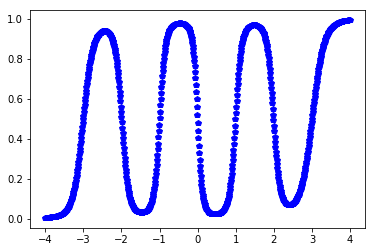

36, 45, 7 ,  0.14049306654150368
34, 35, 7 ,  0.1402230688783912
34, 33, 7 ,  0.13716093796767956
38, 36, 7 ,  0.13820280689930536
35, 36, 7 ,  0.13573456120091715
34, 35, 7 ,  0.13571342229450034
35, 55, 7 ,  0.13610851904694077
36, 36, 7 ,  0.134328202271078
33, 36, 7 ,  0.1342432905869943
33, 34, 7 ,  0.13487834666152296


In [296]:
print(NN.Train(times=500, method="Rprop", is_termination=True), end = ", ")
print(NN.hiddenLayerList[0].num_unit, ", ", NN.GetTrainLoss())

plt.plot(X.reshape(-1), NN.GetInference(NN.trainData.inputs)[:,0], "bp")
plt.show()

for t in range(10):
    NN.AddUnit(layer_index=0, num_added=3, output_linear_bound=0.1)
    print(NN.Train(times=500, method="Rprop", is_termination=True), end = ", ")
    NN.UnitsRefined(layer_index=0, method="remain", threshold=7)
    print(NN.Train(times=500, method="Rprop", is_termination=True), end = ", ")
    print(NN.hiddenLayerList[0].num_unit, ", ", NN.GetTrainLoss())
    if NN.GetTrainLoss()>1.:
        break
    else:
        pre_input = NN.hiddenLayerList[0].flow_out
        pre_output = NN.outputLayer.flow_in
    
    #plt.plot(X.reshape(-1), NN.GetInference(NN.trainData.inputs)[:,0], "bp")
    #plt.show()

# Skew chessboard

In [8]:
X = 4*np.random.rand(20000,2) - 2
Y = np.zeros((X.shape[0],2))
Y[:, 0] = (((np.floor((X[:,0] + X[:,1])%2) + np.floor((X[:,0] - X[:,1])%2)) %2) == 1)
Y[:, 1] = 1- Y[:, 0]

### Training directly

In [17]:
NN = DogikoNeuralNetwork()
NN.SetTrainData(X[:10000], Y[:10000])
NN.SetValidData(X[10000:15000], Y[10000:15000])
NN.SetTestData(X[15000:], Y[15000:])
NN.SetLossFunction("cross entropy")
NN.SetRegularizer(0.0001, 1.)
NN.AddHiddenLayer(20, Hypertan())
NN.AddHiddenLayer(20, Hypertan())
NN.SetOutputFunction(Softmax())
NN.SetTerminator(10,30, -0.)

times = 100
record = np.zeros((times))
for t in range(times):
    NN.Build()
    print(NN.Train(times=1000, batch_size=10000, method="Rprop", is_termination=True), end = ", ")
    for l in range(NN.GetNumHiddenLayers()):
        print(NN.hiddenLayerList[l].num_unit, end = ", ")
    
    print(NN.GetTrainAccuracy(), NN.GetValidAccuracy(), NN.GetTestAccuracy())
    record[t] = NN.GetTestAccuracy()

1000, 20, 20, 0.9062 0.8994 0.902
1000, 20, 20, 0.911 0.9042 0.9122
1000, 20, 20, 0.9175 0.9098 0.9144
1000, 20, 20, 0.8623 0.8576 0.8586
1000, 20, 20, 0.9128 0.9014 0.8984
1000, 20, 20, 0.932 0.9186 0.9232
1000, 20, 20, 0.8837 0.879 0.8776
1000, 20, 20, 0.8994 0.8926 0.8962
1000, 20, 20, 0.8979 0.8856 0.8876
1000, 20, 20, 0.8905 0.887 0.8798
1000, 20, 20, 0.9202 0.912 0.9148
1000, 20, 20, 0.9243 0.9138 0.9146
1000, 20, 20, 0.9147 0.9084 0.9038
1000, 20, 20, 0.8932 0.8882 0.881
1000, 20, 20, 0.8795 0.8726 0.8756
1000, 20, 20, 0.8752 0.8704 0.878
1000, 20, 20, 0.9265 0.9244 0.9212
1000, 20, 20, 0.9184 0.9062 0.91
1000, 20, 20, 0.8646 0.8556 0.8606
1000, 20, 20, 0.9065 0.892 0.898
1000, 20, 20, 0.8766 0.867 0.8742
1000, 20, 20, 0.9053 0.8894 0.8872
1000, 20, 20, 0.8638 0.857 0.8598
1000, 20, 20, 0.8331 0.8272 0.8302
1000, 20, 20, 0.905 0.9012 0.9036
1000, 20, 20, 0.8683 0.8604 0.8618
1000, 20, 20, 0.8884 0.8852 0.8792
1000, 20, 20, 0.9157 0.9104 0.9226
1000, 20, 20, 0.8616 0.8536 0.8518


In [15]:
record.sort()
record[-25]

0.706

### Repeat add-fit-kill-fit for fix number of units

628, 20, 20, 0.6856 0.6838 0.6832
1000, 1000, 20, 20, 0.9629 0.9536 0.951
1000, 791, 20, 20, 0.9692 0.9568 0.9558
1000, 1000, 20, 20, 0.9692 0.9554 0.9564
1000, 1000, 20, 20, 0.97 0.9576 0.9592
1000, 1000, 20, 20, 0.9754 0.96 0.965
1000, 841, 20, 20, 0.9804 0.9652 0.9678
1000, 630, 20, 20, 0.9815 0.9654 0.9726
706, 994, 20, 20, 0.9861 0.9708 0.974
772, 477, 20, 20, 0.9787 0.9662 0.9686
1000, 1000, 20, 20, 0.9809 0.9692 0.971
761, 620, 20, 20, 0.9832 0.9694 0.9702
1000, 1000, 20, 20, 0.9839 0.9692 0.9718
609, 993, 20, 20, 0.9848 0.9694 0.9756
844, 1000, 20, 20, 0.9866 0.9728 0.9778
829, 1000, 20, 20, 0.9856 0.9722 0.9746
650, 1000, 20, 20, 0.9847 0.9698 0.9754
631, 935, 20, 20, 0.9853 0.9726 0.9762
1000, 831, 20, 20, 0.9832 0.9704 0.9728
1000, 1000, 20, 20, 0.9818 0.9678 0.9724
1000, 353, 20, 20, 0.9799 0.968 0.9686


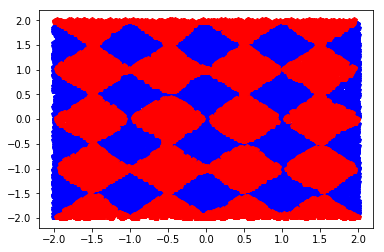

In [16]:
NN = DogikoNeuralNetwork()
NN.SetTrainData(X[:10000], Y[:10000])
NN.SetValidData(X[10000:15000], Y[10000:15000])
NN.SetTestData(X[15000:], Y[15000:])
NN.SetLossFunction("cross entropy")
NN.SetRegularizer(0.0001, 1.)
NN.AddHiddenLayer(20, Hypertan())
NN.AddHiddenLayer(20, Hypertan())
NN.SetOutputFunction(Softmax())
NN.SetTerminator(10,30, -0.)

NN.Build()

print(NN.Train(times=1000, batch_size=5000, method="Rprop", is_termination=True), end = ", ")
for l in range(NN.GetNumHiddenLayers()):
    print(NN.hiddenLayerList[l].num_unit, end = ", ")

print(NN.GetTrainAccuracy(), NN.GetValidAccuracy(), NN.GetTestAccuracy())

for t in range(20):
    for l in range(NN.GetNumHiddenLayers()):
        NN.AddUnit(layer_index=l, num_added=2, output_linear_bound=0.01)
    
    NN.ResetCwiseStep(0.001)
    print(NN.Train(times=1000, batch_size=10000, method="Rprop", is_termination=True), end = ", ")
    for l in range(NN.GetNumHiddenLayers()):
        NN.UnitsRefined(layer_index=l, method="remove", threshold=2)
    
    NN.ResetCwiseStep(0.001)
    print(NN.Train(times=1000, batch_size=10000, method="Rprop", is_termination=True), end = ", ")
    for l in range(NN.GetNumHiddenLayers()):
        print(NN.hiddenLayerList[l].num_unit, end = ", ")
    
    print(NN.GetTrainAccuracy(), NN.GetValidAccuracy(), NN.GetTestAccuracy())

I = NN.GetInference(X)[:, 0]
plt.plot(X[:, 0][I>0.5], X[:, 1][I>0.5], "bp")
plt.plot(X[:, 0][I<0.5], X[:, 1][I<0.5], "rp")
plt.show()

### Find suitable units by info ratio of layer output

669, 20, 20, 0.7337 0.7306 0.7342
1000, 1000, 12, 19, 0.9507 0.939 0.9452
1000, 1000, 12, 20, 0.967 0.9508 0.9572
1000, 1000, 12, 21, 0.9759 0.9588 0.9618
319, 810, 12, 21, 0.9735 0.9594 0.9612
1000, 998, 12, 21, 0.9755 0.96 0.9638
273, 1000, 12, 20, 0.9779 0.9634 0.9662
383, 1000, 12, 21, 0.9804 0.9642 0.969
865, 223, 12, 21, 0.9816 0.9678 0.9696
554, 675, 12, 21, 0.9829 0.967 0.9702
562, 463, 12, 21, 0.9816 0.9692 0.9684
233, 998, 12, 20, 0.9827 0.9688 0.9704
299, 297, 12, 21, 0.9825 0.9682 0.9706
299, 633, 13, 22, 0.9833 0.9688 0.9698
300, 1000, 13, 23, 0.9764 0.962 0.9666
821, 1000, 12, 23, 0.9819 0.9674 0.9666
810, 328, 13, 23, 0.981 0.9672 0.969
537, 323, 13, 24, 0.9826 0.968 0.971
1000, 393, 14, 25, 0.9861 0.97 0.9734
281, 680, 14, 25, 0.9847 0.9696 0.971
672, 262, 13, 25, 0.9818 0.969 0.9704


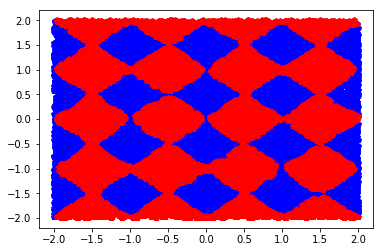

In [24]:
NN = DogikoNeuralNetwork()
NN.SetTrainData(X[:10000], Y[:10000])
NN.SetValidData(X[10000:15000], Y[10000:15000])
NN.SetTestData(X[15000:], Y[15000:])
NN.SetLossFunction("cross entropy")
NN.SetRegularizer(0.0001, 1.)
NN.AddHiddenLayer(20, Hypertan())
NN.AddHiddenLayer(20, Hypertan())
NN.SetOutputFunction(Softmax())
NN.SetTerminator(10,30, -0.)

NN.Build()

print(NN.Train(times=1000, batch_size=5000, method="Rprop", is_termination=True), end = ", ")
for l in range(NN.GetNumHiddenLayers()):
    print(NN.hiddenLayerList[l].num_unit, end = ", ")

print(NN.GetTrainAccuracy(), NN.GetValidAccuracy(), NN.GetTestAccuracy())

for t in range(20):
    for l in range(NN.GetNumHiddenLayers()):
        NN.AddUnit(layer_index=l, num_added=1, output_linear_bound=0.01)
    
    NN.ResetCwiseStep(0.001)
    print(NN.Train(times=1000, batch_size=10000, method="Rprop", is_termination=True), end = ", ")
    for l in range(NN.GetNumHiddenLayers()):
        NN.UnitsRefined(layer_index=l, method="info ratio", threshold=0.001)
    
    NN.ResetCwiseStep(0.001)
    print(NN.Train(times=1000, batch_size=10000, method="Rprop", is_termination=True), end = ", ")
    for l in range(NN.GetNumHiddenLayers()):
        print(NN.hiddenLayerList[l].num_unit, end = ", ")
    
    print(NN.GetTrainAccuracy(), NN.GetValidAccuracy(), NN.GetTestAccuracy())

I = NN.GetInference(X)[:, 0]
plt.plot(X[:, 0][I>0.5], X[:, 1][I>0.5], "bp")
plt.plot(X[:, 0][I<0.5], X[:, 1][I<0.5], "rp")
plt.show()

# "Is Skin" on UCI

In [25]:
X = np.load("../UCI/Is-skin/data-npy/data.npy").astype(np.float64)
Y = np.load("../UCI/Is-skin/data-npy/label.npy").astype(np.float64)
X *= 2/255
X -= 1
shuffle = np.arange(X.shape[0])
np.random.shuffle(shuffle)
X = X[shuffle]
Y = Y[shuffle]

### Train directly

In [6]:
NN = DogikoNeuralNetwork()
NN.SetTrainData(X[:150000], Y[:150000])
NN.SetValidData(X[150000:200000], Y[150000:200000])
NN.SetTestData(X[200000:], Y[200000:])
NN.SetLossFunction("cross entropy")
NN.SetRegularizer(0.0001, 0.)
NN.AddHiddenLayer(2, Hypertan())
NN.SetOutputFunction(Softmax())
NN.SetTerminator(10,30, -0.01)
for t in range(10):
    NN.Build()
    print(NN.Train(times=2000, batch_size=50000, method="Rprop", is_termination=True), end = ", ")
    print(NN.GetTrainAccuracy(), NN.GetValidAccuracy(), NN.GetTestAccuracy())

85, 2, 0.976 0.9769 0.9765
88, 2, 0.9778 0.9779 0.9771
96, 2, 0.9947 0.9948 0.9948
77, 2, 0.9781 0.9789 0.9785
82, 2, 0.9777 0.9778 0.9771
114, 2, 0.9938 0.9941 0.9939
94, 2, 0.978 0.9779 0.9775
102, 2, 0.9783 0.9783 0.9779
87, 2, 0.977 0.9771 0.9763
84, 2, 0.9783 0.9785 0.9779


### Repeat add-fit-kill-fit for fix number of units

In [9]:
NN = DogikoNeuralNetwork()
NN.SetTrainData(X[:150000], Y[:150000])
NN.SetValidData(X[150000:200000], Y[150000:200000])
NN.SetTestData(X[200000:], Y[200000:])
NN.SetLossFunction("cross entropy")
NN.SetRegularizer(0.0001, 1.)
NN.AddHiddenLayer(2, Hypertan())
NN.SetOutputFunction(Softmax())
NN.SetTerminator(10,30, -0.)

NN.Build()

print(NN.Train(times=2000, batch_size=50000, method="Rprop", is_termination=True), end = ", ")
for l in range(NN.GetNumHiddenLayers()):
    print(NN.hiddenLayerList[l].num_unit, end = ", ")

print(NN.GetTrainAccuracy(), NN.GetValidAccuracy(), NN.GetTestAccuracy())

for t in range(10):
    for l in range(NN.GetNumHiddenLayers()):
        NN.AddUnit(layer_index=l, num_added=1, output_linear_bound=0.01)
    
    NN.ResetCwiseStep(0.001)
    print(NN.Train(times=2000, batch_size=50000, method="Rprop", is_termination=True), end = ", ")
    for l in range(NN.GetNumHiddenLayers()):
        NN.UnitsRefined(layer_index=l, method="remain", threshold=2, enhance_alert=False)
    
    NN.ResetCwiseStep(0.001)
    print(NN.Train(times=2000, batch_size=50000, method="Rprop", is_termination=True), end = ", ")
    for l in range(NN.GetNumHiddenLayers()):
        print(NN.hiddenLayerList[l].num_unit, end = ", ")
    
    print(NN.GetTrainAccuracy(), NN.GetValidAccuracy(), NN.GetTestAccuracy())

79, 2, 0.9781 0.9782 0.9775
42, 32, 2, 0.9783 0.9784 0.9781
127, 75, 2, 0.9945 0.9946 0.9945
56, 117, 2, 0.9947 0.9948 0.9948
234, 31, 2, 0.9945 0.9945 0.9945
149, 34, 2, 0.9945 0.9945 0.9946
60, 31, 2, 0.9945 0.9944 0.9947
40, 97, 2, 0.992 0.9921 0.9924
32, 81, 2, 0.994 0.9941 0.994
35, 96, 2, 0.9945 0.9946 0.9944
167, 236, 2, 0.9901 0.9898 0.9902


### Find suitable units by info ratio of layer output

In [35]:
NN = DogikoNeuralNetwork()
NN.SetTrainData(X[:150000], Y[:150000])
NN.SetValidData(X[150000:200000], Y[150000:200000])
NN.SetTestData(X[200000:], Y[200000:])
NN.SetLossFunction("cross entropy")
NN.SetRegularizer(0.0001, 0.)
NN.AddHiddenLayer(10, Hypertan())
NN.SetOutputFunction(Softmax())
NN.SetTerminator(10,30, -0.01)

NN.Build()

print(NN.Train(times=2000, batch_size=50000, method="Rprop", is_termination=True), end = ", ")
for l in range(NN.GetNumHiddenLayers()):
    print(NN.hiddenLayerList[l].num_unit, end = ", ")

print(NN.GetTrainAccuracy(), NN.GetValidAccuracy(), NN.GetTestAccuracy())

for t in range(20):
    for l in range(NN.GetNumHiddenLayers()):
        NN.AddUnit(layer_index=l, num_added=1, output_linear_bound=0.01)
    
    NN.ResetCwiseStep(0.001)
    print(NN.Train(times=2000, batch_size=50000, method="Rprop", is_termination=True), end = ", ")
    for l in range(NN.GetNumHiddenLayers()):
        NN.UnitsRefined(layer_index=l, method="info ratio", threshold=0.0001)
    
    NN.ResetCwiseStep(0.001)
    print(NN.Train(times=2000, batch_size=50000, method="Rprop", is_termination=True), end = ", ")
    for l in range(NN.GetNumHiddenLayers()):
        print(NN.hiddenLayerList[l].num_unit, end = ", ")
    
    print(NN.GetTrainAccuracy(), NN.GetValidAccuracy(), NN.GetTestAccuracy())

133, 10, 0.9971 0.9974 0.9973
90, 37, 9, 0.9974 0.9976 0.9975
33, 34, 9, 0.9974 0.9976 0.9976
33, 32, 8, 0.9976 0.9978 0.9976
31, 34, 8, 0.9976 0.9978 0.9977
35, 34, 7, 0.9976 0.9978 0.9977
34, 31, 7, 0.9975 0.9977 0.9976
32, 31, 6, 0.9977 0.9978 0.9977
32, 33, 6, 0.9976 0.9979 0.9977
32, 31, 6, 0.9976 0.9979 0.9977
32, 31, 6, 0.9977 0.9979 0.9978
33, 31, 6, 0.9976 0.9979 0.9978
31, 31, 6, 0.9976 0.9978 0.9977
31, 31, 6, 0.9976 0.9978 0.9977
31, 31, 6, 0.9976 0.9979 0.9977
31, 31, 6, 0.9975 0.9978 0.9977
32, 32, 6, 0.9977 0.9979 0.9978
30, 31, 6, 0.9976 0.9979 0.9978
31, 31, 6, 0.9976 0.9978 0.9978
33, 31, 6, 0.9976 0.9978 0.9977
46, 32, 7, 0.9976 0.9978 0.9978


# Background delete for nokia machine

In [26]:
X_train = np.zeros((300000, 900))
Y_train = np.zeros((300000, 2))

X_valid = np.zeros((20000, 900))
Y_valid = np.zeros((20000, 2))


name = [0, 650]
for f in range(len(name)):
    file = name[f]
    shuffle = np.arange(450*600)
    np.random.shuffle(shuffle)
    shuffle = shuffle[:110000]
    
    X_train[100000*f:100000*(f+1)] = np.load("../../linker/Nokia/frame%d_inputs.npy" %(file)).astype(np.float64)[shuffle[:100000]]
    Y_train[100000*f:100000*(f+1),0]=np.load("../../linker/Nokia/frame%d_labels.npy" %(file))[shuffle[:100000]]
    Y_train[100000*f:100000*(f+1),1]=1-Y_train[100000*f:100000*(f+1),0]
    
    X_valid[10000*f:10000*(f+1)] = np.load("../../linker/Nokia/frame%d_inputs.npy" %(file)).astype(np.float64)[shuffle[100000:]]
    Y_valid[10000*f:10000*(f+1),0]=np.load("../../linker/Nokia/frame%d_labels.npy" %(file))[shuffle[100000:]]
    Y_valid[10000*f:10000*(f+1),1]=1-Y_valid[10000*f:10000*(f+1),0]

shuffle = np.arange(180*500)
np.random.shuffle(shuffle)
shuffle = shuffle[:50000]

X_train[200000:250000] = np.load("../../linker/Nokia/frame300_part_inputs.npy").astype(np.float64)[:50000]
Y_train[200000:250000, 0] = np.load("../../linker/Nokia/frame300_part_labels.npy")[:50000]
Y_train[200000:250000, 1] = 1 - Y_train[200000:250000, 0]

X_train[250000:] = np.load("../../linker/Nokia/frame1335_part_inputs.npy").astype(np.float64)[shuffle]
Y_train[250000:, 0] = np.load("../../linker/Nokia/frame1335_part_labels.npy")[shuffle]
Y_train[250000:, 1] = 1 - Y_train[250000:, 0]

NN = DogikoNeuralNetwork()
NN.SetTrainData(X_train, Y_train)
NN.SetValidData(X_valid, Y_valid)
NN.SetTestData(X_valid, Y_valid)


NN.SetLossFunction("cross entropy")
NN.SetRegularizer(0.01, 3.)
NN.AddHiddenLayer(1000, Hypertan())
NN.AddHiddenLayer(100, Hypertan())
NN.SetOutputFunction(Softmax())
NN.SetTerminator(5,10,-0.0)
NN.Build()

print("done")

done


In [3]:
X_train = np.zeros((10,900))
Y_train = np.zeros((10,2))

NN = DogikoNeuralNetwork()
NN.SetTrainData(X_train, Y_train)
NN.SetValidData(X_train, Y_train)
NN.SetTestData(X_train, Y_train)
NN.load_model("../../linker/Nokia/get")

In [27]:
NN.Train(times=200, method="Rprop", is_termination=True)

KeyboardInterrupt: 

In [ ]:
print(NN.GetTrainAccuracy())
print(NN.GetValidAccuracy())

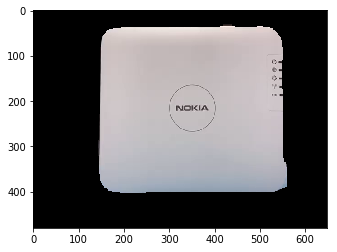

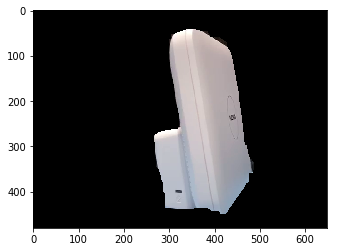

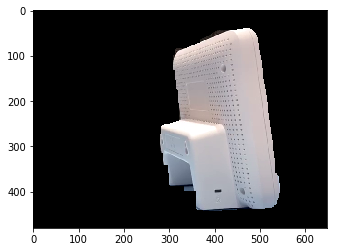

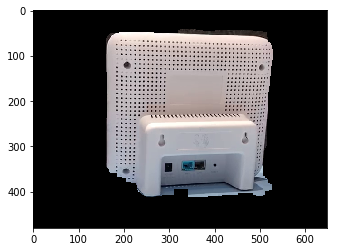

In [66]:
import cv2
for f in [0, 300, 400, 650]:
    img = np.load("../../linker/Nokia/frame%d.npy" %(f))
    img_array = np.load("../../linker/Nokia/frame%d_inputs.npy" %(f))
    mask = np.zeros((480,648), np.uint8)
    mask[7:457, 7:607] = (NN.GetInference(img_array)[:,0]>0.5).reshape(450,600).astype(np.uint8)
    
    kernel = np.ones((7,7), np.uint8)
    mask = cv2.erode(mask, kernel, iterations=3)
    mask = cv2.dilate(mask, kernel, iterations=6)
    mask = cv2.erode(mask, kernel, iterations=4)
    for c in range(3):
        img[:,:,c] *= mask
    
    plt.imshow(img)
    plt.show()

In [41]:
NN.save_model("../../linker/Nokia/get")

In [6]:
import cv2

vidcap = cv2.VideoCapture("../../linker/Nokia/movie-A.MP4")

success = True
success, img = vidcap.read()

counter = 0
kernel = np.ones((9,9), np.uint8)
while True:
    success, img = vidcap.read()
    
    if not success:
        break
    
    if ((counter % 15) == 0):
        print(counter)
        img = img[:,100:-100]
        info = np.zeros(img.shape[:2]+ (4,))
        info[:,:,3] = img.mean(axis=2)/255
        info[:,:,:3] = Softmax().Forward(img.reshape(-1,3)/10).reshape(img.shape)
        data = np.zeros((450, 600, 15*15*4))
        for i in range(15):
            for j in range(15):
                data[:,:,60*i+4*j:60*i+4*j+4] = info[i:i+450, j:j+600]
        
        mask = np.zeros((680,848), np.uint8)
        mask[107:557, 107:707] = (NN.GetInference(data.reshape(-1,15*15*4))[:,0]>0.5).reshape(450,600).astype(np.uint8)
        
        mask = cv2.dilate(mask, kernel, iterations=8)
        mask = cv2.erode(mask, kernel, iterations=8)
        
        mask = mask[100:-100, 100:-100]
        
        png = np.zeros(img.shape[:2]+ (4,), dtype=np.uint8)
        
        png[:,:,:3] = img
        png[:,:,3] = mask*255
        
        cv2.imwrite("../../linker/Nokia/pngs/movie-A/frame%s.png" %(str(counter).zfill(4)), png[:500, 150:-50])
    
    counter += 1

print("down")

0
15
30
45
60
75
90
105
120
135
150
165
180
195
210
225
240
255
270
285
300
315
330
345
360
375
390
405
420
435
450
465
480
495
510
525
540
555
570
585
600
615
630
645
660
675
690
705
720
735
750
765
780
795
810
825
840
855
870
885
900
915
930
945
960
975
990
1005
1020
1035
1050
1065
1080
1095
1110
1125
1140
1155
1170
1185
1200
1215
1230
1245
1260
1275
1290
1305
1320
1335
1350
down


# Case movie-d

rotate first

In [18]:
import cv2

vidcap = cv2.VideoCapture("../../linker/Nokia/movie-D.MP4")

success = True
success, img = vidcap.read()

counter = 0
kernel = np.ones((9,9), np.uint8)
while True:
    success, img = vidcap.read()
    
    if not success:
        break
    
    if ((counter % 15) == 0):
        print(counter)
        img = img[:,100:-100]
        img = np.rot90(img,3)
        """
        info = np.zeros(img.shape[:2]+ (4,))
        info[:,:,3] = img.mean(axis=2)/255
        info[:,:,:3] = Softmax().Forward(img.reshape(-1,3)/10).reshape(img.shape)
        data = np.zeros((600, 450, 15*15*4))
        for i in range(15):
            for j in range(15):
                data[:,:,60*i+4*j:60*i+4*j+4] = info[i:i+600, j:j+450]
        
        mask = np.zeros((848, 680), np.uint8)
        mask[107:707, 107:557] = (NN.GetInference(data.reshape(-1,15*15*4))[:,0]>0.5).reshape(600,450).astype(np.uint8)
        
        mask = cv2.dilate(mask, kernel, iterations=8)
        mask = cv2.erode(mask, kernel, iterations=8)
        
        mask = mask[100:-100, 100:-100]
        
        png = np.zeros(img.shape[:2]+ (4,), dtype=np.uint8)
        """
        png[:,:,:3] = img
        png[:,:,3] = 255
        cv2.imwrite("../../linker/Nokia/pngs/movie-D/frame%s.png" %(str(counter).zfill(4)), png)
        
    
    counter += 1

print("down")

0
15
30
45
60
75
90
105
120
135
150
165
180
195
210
225
240
255
270
285
300
315
330
345
360
375
390
405
420
435
450
465
480
495
510
525
540
555
570
585
600
615
630
645
660
675
690
705
720
735
750
765
780
795
810
825
840
855
870
885
900
915
930
945
960
975
990
1005
1020
1035
1050
1065
1080
1095
1110
1125
1140
1155
1170
1185
1200
1215
1230
1245
1260
1275
1290
1305
1320
1335
1350
1365
1380
1395
1410
1425
1440
1455
1470
1485
1500
1515
1530
1545
1560
1575
1590
1605
1620
1635
1650
1665
1680
1695
1710
1725
1740
1755
1770
1785
1800
1815
1830
1845
1860
1875
1890
1905
down


In [3]:
np.load("../UCI/Is-skin/data-npy/label.npy")

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [4]:
np.array([[1,2,4], [5,7,3]]).sum(axis=0)

array([6, 9, 7])

In [167]:
foo = NN.hiddenLayerList[0].flow_out

In [168]:
np.linalg.lstsq(NN.hiddenLayerList[0].flow_out, NN.outputLayer.flow_in, rcond=0.001)

(array([[15.57516062],
        [ 1.88070321],
        [-0.39707044],
        [ 6.92414886],
        [ 6.0204971 ],
        [-5.73028908],
        [-6.02278049]]),
 array([3.32585635]),
 7,
 array([48.11841392, 37.14873468, 13.41558738,  6.72230468,  3.38750477,
         0.73388014,  0.09499008]))

In [169]:
foo -= foo.mean(axis=0)

In [170]:
foo /= foo.std(axis=0)

In [171]:
cov = np.dot(foo.T, foo)/len(foo)

In [172]:
(np.abs(cov).sum(axis=0)-1)/(7-1)

array([0.83316332, 0.83081517, 0.81391293, 0.77336573, 0.77445172,
       0.68625918, 0.64827403])

In [173]:
np.round(cov, 2)

array([[ 1.  ,  0.84,  1.  ,  0.75, -0.89,  0.63,  0.89],
       [ 0.84,  1.  ,  0.81,  0.98, -0.85,  0.92,  0.58],
       [ 1.  ,  0.81,  1.  ,  0.71, -0.87,  0.59,  0.91],
       [ 0.75,  0.98,  0.71,  1.  , -0.76,  0.96,  0.48],
       [-0.89, -0.85, -0.87, -0.76,  1.  , -0.63, -0.64],
       [ 0.63,  0.92,  0.59,  0.96, -0.63,  1.  ,  0.38],
       [ 0.89,  0.58,  0.91,  0.48, -0.64,  0.38,  1.  ]])

In [174]:
from scipy import stats

In [176]:
for i in range(7):
    print(np.linalg.norm(np.linalg.lstsq(foo[:, np.arange(7)!=i], foo, rcond=0.000000001)[1]/len(foo)))

NN.hiddenLayerList[0].linear.SetValue(NN.hiddenLayerList[0].linear.value[:, np.arange(7)!=0])
NN.hiddenLayerList[0].bias.SetValue(NN.hiddenLayerList[0].bias.value[:, np.arange(7)!=0])
NN.outputLayer.linear.SetValue(NN.outputLayer.linear.value[np.arange(7)!=0, :])
NN.GetTrainLoss()

3.6592794308938296e-05
0.0005014575179839885
4.672863540624664e-05
0.001695144129893332
0.04033132032837475
0.05317543532530842
0.04963481838602482


In [180]:
NN.hiddenLayerList[0].linear.SetValue(NN.hiddenLayerList[0].linear.value[:, np.arange(7)!=0])

In [181]:
NN.hiddenLayerList[0].bias.SetValue(NN.hiddenLayerList[0].bias.value[:, np.arange(7)!=0])

In [185]:
NN.outputLayer.linear.SetValue(NN.outputLayer.linear.value[np.arange(7)!=0, :])

In [186]:
NN.GetInference(NN.trainData.inputs)

array([[7.17522574e-01],
       [7.20480714e-01],
       [7.23441946e-01],
       [7.26405824e-01],
       [7.29371892e-01],
       [7.32339688e-01],
       [7.35308747e-01],
       [7.38278593e-01],
       [7.41248749e-01],
       [7.44218730e-01],
       [7.47188045e-01],
       [7.50156199e-01],
       [7.53122694e-01],
       [7.56087024e-01],
       [7.59048682e-01],
       [7.62007155e-01],
       [7.64961927e-01],
       [7.67912478e-01],
       [7.70858287e-01],
       [7.73798829e-01],
       [7.76733576e-01],
       [7.79661999e-01],
       [7.82583568e-01],
       [7.85497750e-01],
       [7.88404012e-01],
       [7.91301822e-01],
       [7.94190645e-01],
       [7.97069948e-01],
       [7.99939199e-01],
       [8.02797866e-01],
       [8.05645419e-01],
       [8.08481330e-01],
       [8.11305072e-01],
       [8.14116122e-01],
       [8.16913961e-01],
       [8.19698070e-01],
       [8.22467939e-01],
       [8.25223057e-01],
       [8.27962921e-01],
       [8.30687032e-01],


In [187]:
NN.GetTrainLoss()

1.3695636923010241

In [80]:
foo = np.random.normal(0, 1, (100000, 100))
fooo = np.dot(foo, np.random.rand(100,100))

In [84]:
np.linalg.lstsq(foo, fooo, rcond=0.000000001)

(array([[0.29521002, 0.45843614, 0.11859997, ..., 0.8700029 , 0.54711347,
         0.5780524 ],
        [0.70549313, 0.58648321, 0.24346404, ..., 0.66681121, 0.44254001,
         0.12050356],
        [0.38177025, 0.79733748, 0.35448559, ..., 0.59725031, 0.14655704,
         0.21266997],
        ...,
        [0.12837263, 0.54828083, 0.10380535, ..., 0.95960302, 0.44130047,
         0.96294612],
        [0.64075634, 0.87398198, 0.38993293, ..., 0.89630935, 0.74464654,
         0.02221745],
        [0.08175915, 0.92183676, 0.53403716, ..., 0.51229442, 0.02674227,
         0.50541824]]),
 array([2.64522119e-25, 4.36902146e-25, 3.53763794e-25, 4.28677863e-25,
        3.48236637e-25, 3.86638961e-25, 3.55324743e-25, 4.15293861e-25,
        3.23457786e-25, 3.84414808e-25, 3.04640250e-25, 3.82559045e-25,
        3.19113476e-25, 3.62573841e-25, 3.21332110e-25, 3.26403574e-25,
        3.80402933e-25, 3.22420708e-25, 4.41243450e-25, 3.19761808e-25,
        4.15491832e-25, 3.27173109e-25, 3.1519608

In [273]:
foo = np.random.normal(1., 1., (100,3))
#foo[:,2] = 0.5*foo[:,1] 

In [255]:
LinearRefine(foo, foo, 1)

(array([False,  True,  True]), array([[0.13223261, 0.8       , 0.4       ],
        [0.06611631, 0.4       , 0.2       ]]), array([[ 8.53395007e-01, -1.23359110e-17, -6.16795551e-18]]), array([], dtype=float64))

In [274]:
result = np.linalg.lstsq(np.c_[foo[:,:2], np.ones(100)], foo)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [275]:
((np.dot(np.c_[foo[:,:2], np.ones(100)], result[0]) - foo)**2).sum(axis=0)

array([1.00952072e-29, 4.52263240e-29, 1.04699458e+02])

In [276]:
result

(array([[ 1.00000000e+00, -3.70515976e-16,  2.16714949e-02],
        [-1.76554655e-18,  1.00000000e+00,  1.53773312e-01],
        [-9.29332965e-17, -2.09841310e-16,  7.65286657e-01]]),
 array([5.12653763e-29, 2.79139902e-30, 1.04699458e+02]),
 3,
 array([19.53378013,  9.11490604,  5.41135723]))